In [1]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_alex=load_model('../model_alex/checkpoint.pth.tar')

=> loading checkpoint '../model_alex/checkpoint.pth.tar'
Loaded


In [4]:
model_alex.cuda()
model_alex.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

In [5]:
data_dir = '/home/aogorodnikov/eval'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [6]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        with torch.no_grad():
            input_var = torch.autograd.Variable(input_tensor.cuda())
            aux = model(input_var).data.cpu().numpy()
            if i == 0:
                features = np.zeros((N, aux.shape[1])).astype('float32')

            if i < len(dataloader) - 1:
                features[i * 256: (i + 1) * 256] = aux.astype('float32')
            else:
                # special treatment for final batch
                features[i * 256:] = aux.astype('float32')

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        

    return features

In [ ]:
for i, (input_tensor, _) in enumerate(dataloader):
    print(input_tensor)

In [ ]:
nput_var = torch.autograd.Variable(input_tensor.cuda())
nput_var

In [11]:
class AlexNetConv3(nn.Module):
            def __init__(self):
                super(AlexNetConv3, self).__init__()
                self.features = nn.Sequential(
                    # stop at conv4
                    *[model_alex.features[i] for i in range(11)]
                    #*list(model_alex.features.children())[:-7]
                )
            def forward(self, x):
                x = self.features(x)
                return x

model = AlexNetConv3()
model.cuda()



AlexNetConv3(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
  )
)

In [33]:
model(input_tensor.cuda())

RuntimeError: Given groups=1, weight of size 96 2 11 11, expected input[256, 3, 224, 224] to have 2 channels, but got 3 channels instead

In [35]:
features = compute_features(dataloader, model, len(dataset))

RuntimeError: Given groups=1, weight of size 96 2 11 11, expected input[256, 3, 224, 224] to have 2 channels, but got 3 channels instead

In [ ]:
features.shape

In [5]:
model.top_layer = None
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

In [6]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        input_var = torch.autograd.Variable(input_tensor.cuda(), volatile=True)
        aux = model(input_var).data.cpu().numpy()

        if i == 0:
            features = np.zeros((N, aux.shape[1])).astype('float32')

        if i < len(dataloader) - 1:
            features[i * 256: (i + 1) * 256] = aux.astype('float32')
        else:
            # special treatment for final batch
            features[i * 256:] = aux.astype('float32')

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    return features

In [7]:
data_dir = '/home/aogorodnikov/data'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [8]:
features = compute_features(dataloader, model, len(dataset))

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


In [9]:
features.shape

(590, 4096)

In [21]:
sum(features[0] < 0)

3897

In [45]:
features

array([[-0.5596711 , -0.35947025, -0.29771793, ..., -0.65397936,
        -0.45604262, -1.5110652 ],
       [-0.5332184 , -0.24153075, -0.1778497 , ..., -0.48728308,
        -0.41578782, -1.4455469 ],
       [-0.562844  , -0.35960478, -0.253098  , ..., -0.75592154,
        -0.4083547 , -2.473086  ],
       ...,
       [-0.6977148 , -0.42748675, -0.30365384, ..., -0.8644413 ,
        -0.5260023 ,  0.13039158],
       [-0.6362522 , -0.35282803, -0.40570813, ..., -0.5041059 ,
        -0.46258137, -1.0380186 ],
       [-0.71145654, -0.45314556, -0.30620292, ..., -0.89401263,
        -0.42619962, -0.26017237]], dtype=float32)

In [51]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index  

def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

## 

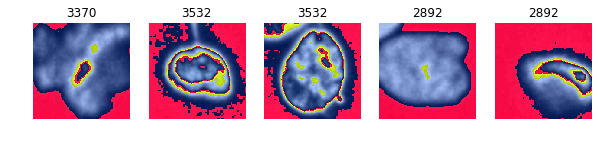

In [54]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(index)
    plt.axis('off')
    plt.imshow(image)
plt.show()